In [1]:
%matplotlib inline
import sys
sys.path.append('..')

import pickle
import numpy as np
import matplotlib.pyplot as plt

from model import lorenz63_fdm, M
from assimilation import OI, ExtendedKF, EnKF, M3DVar

In [2]:
X_nature = np.load('./data/X_nature.npy')
X_ini = np.load('./data/X_ini.npy')
ts = np.load('./data/time_span.npy')
Pb = np.load('./data/Pb.npy')
R = np.load('./data/R.npy')

In [3]:
dt = 0.01
obs_intv = 8

In [4]:
# generate initial ensemble
N_ens = 30
rng = np.random.RandomState(42)
X_ens_ini = rng.multivariate_normal(X_ini.ravel(), Pb, size=N_ens).T  # (3, N_ens)

In [5]:
def RMSE(forecast, nature):
    return np.sqrt(np.mean((forecast-nature)**2, axis=0))

# Assimilate normal observations

0.9408792138195026


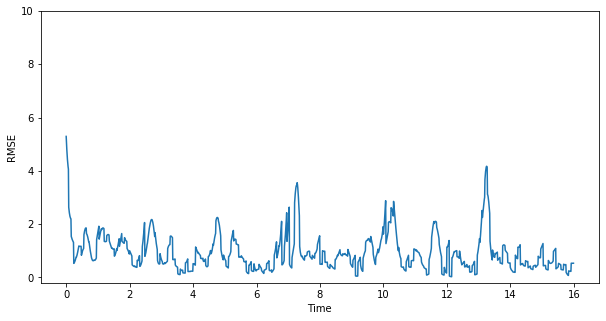

In [7]:
# normal observation
X_obs = np.load('./data/obs_normal.npy')

ekf = ExtendedKF(lorenz63_fdm, dt)
ekf.list_params()
params = {
    'X_ini': X_ini,
    'obs': X_obs,
    'obs_interv': 8,
    'Pb': Pb,
    'R': R,
    'H_func': lambda arr: arr,
    'H': np.eye(3),
    'M': lambda X: M(X.ravel(), dt),
    'alpha': 0.3,
    'inflat': 1.4
}
ekf.set_params(**params)
ekf.cycle()

rmse_ekf = RMSE(ekf.analysis, X_nature)

plt.figure(figsize=(10, 5))
plt.plot(ts, rmse_ekf)
plt.xlabel('Time')
plt.ylabel('RMSE')
plt.ylim([-0.2, 10])
print(rmse_ekf.mean())

# Gamma distribution

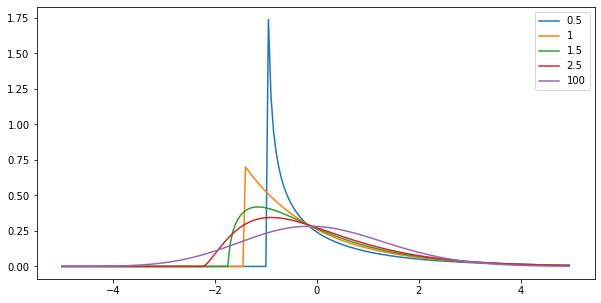

In [8]:
from scipy.stats import gamma

plt.figure(figsize=(10, 5))

x = np.arange(-5, 5, 0.05)
alphas = [0.5, 1, 1.5, 2.5, 100]
for alpha in alphas:
    beta = np.sqrt(2/alpha)
    loc = -np.sqrt(2*alpha)
    pdf = gamma.pdf(x, alpha, loc=loc, scale=beta)
    plt.plot(x, pdf, label=f'{alpha}')
plt.legend();

### Generate observations

In [9]:
ex_obs_dict = {}

alphas = [0.5, 1, 1.5, 2.5, 100]
for alpha in alphas:
    beta = np.sqrt(2/alpha)
    loc = -np.sqrt(2*alpha)
    samples = gamma.rvs(alpha, loc=loc, scale=beta, size=X_nature.shape)
    
    samples_c = samples.copy()
    samples_c[:,::obs_intv] = 0
    samples = samples - samples_c
    X_obserr = samples
        
    X_obs = X_nature + X_obserr
    X_obs = X_obs[:,::obs_intv]
    
    key = f'{alpha:.1f}'
    ex_obs_dict[key] = X_obs
    
ex_obs_dict.keys()

dict_keys(['0.5', '1.0', '1.5', '2.5', '100.0'])

### Assimilate gamma observations

0.5 0.8092393793868393 0.2986600448827148
1.0 0.9423509298430212 0.4972268456660821
1.5 0.9797816056525442 0.6051767730629948
2.5 0.9738449747937284 0.6455621741419284
100.0 1.037891764653373 1.002165782364882


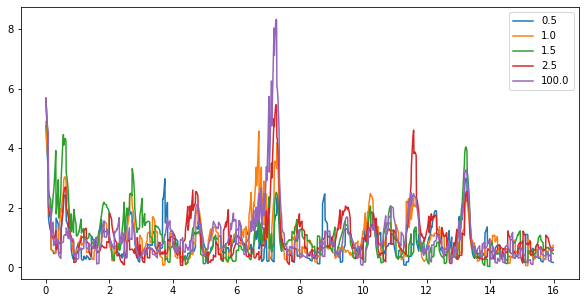

In [11]:
plt.figure(figsize=(10, 5))

for key, obs in ex_obs_dict.items():
    ekf = ExtendedKF(lorenz63_fdm, dt)
    ekf.list_params()
    params = {
        'X_ini': X_ini,
        'obs': obs,
        'obs_interv': 8,
        'Pb': Pb,
        'R': R,
        'H_func': lambda arr: arr,
        'H': np.eye(3),
        'M': lambda X: M(X.ravel(), dt),
        'alpha': 0.3,
        'inflat': 1.4
    }
    ekf.set_params(**params)
    ekf.cycle()

    rmse_ekf = RMSE(ekf.analysis, X_nature)

    plt.plot(ts, rmse_ekf, label=key)
    print(key, rmse_ekf.mean(), rmse_ekf.var())

plt.legend();

# Cauchy

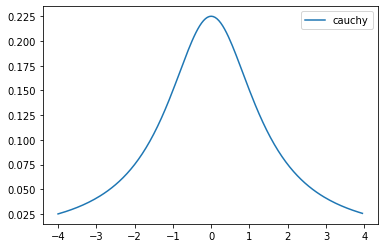

In [12]:
from scipy.stats import cauchy, norm

x = np.arange(-4, 4, 0.05)
plt.plot(x, cauchy.pdf(x, scale=np.sqrt(2)), label='cauchy')
plt.legend();

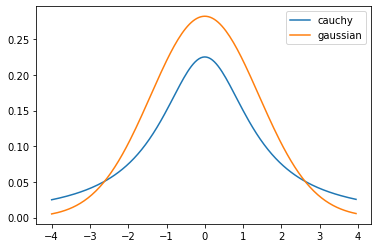

In [13]:
x = np.arange(-4, 4, 0.05)
plt.plot(x, cauchy.pdf(x, scale=np.sqrt(2)), label='cauchy')
plt.plot(x, norm.pdf(x, scale=np.sqrt(2)), label='gaussian')
plt.legend();

### Generate chauchy observation

In [14]:
samples = cauchy.rvs(scale=np.sqrt(2), size=X_nature.shape)
   
samples_c = samples.copy()
samples_c[:,::obs_intv] = 0
samples = samples - samples_c
X_obserr = samples
        
X_obs = X_nature + X_obserr
X_obs = X_obs[:,::obs_intv]

C:\Users\dog\Anaconda3\envs\work\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in square
  


nan nan


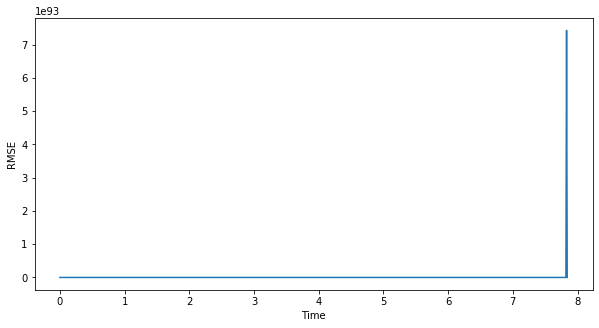

In [16]:
plt.figure(figsize=(10, 5))

ekf = ExtendedKF(lorenz63_fdm, dt)
params = {
    'X_ini': X_ini,
    'obs': X_obs,
    'obs_interv': 8,
    'Pb': Pb,
    'R': R,
    'H_func': lambda arr: arr,
    'H': np.eye(3),
    'M': lambda X: M(X.ravel(), dt),
    'alpha': 0.3,
    'inflat': 1.4
}
ekf.set_params(**params)
ekf.cycle()

rmse_ekf = RMSE(ekf.analysis, X_nature)

plt.plot(ts, rmse_ekf)
plt.xlabel('Time')
plt.ylabel('RMSE')
print(rmse_ekf.mean(), rmse_ekf.var())

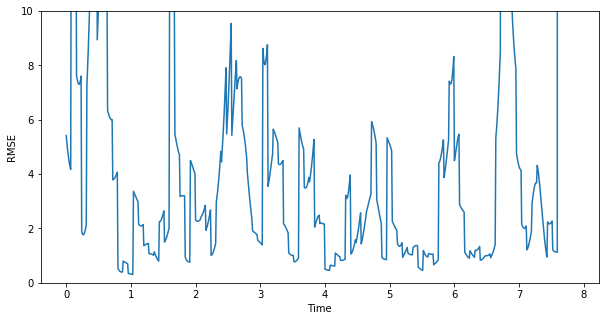

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(ts, rmse_ekf)
plt.xlabel('Time')
plt.ylabel('RMSE')
plt.ylim([0, 10]);

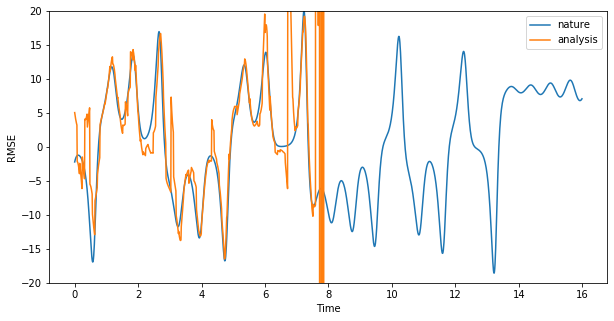

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(ts, X_nature[0,:], label='nature')
plt.plot(ts, ekf.analysis[0,:], label='analysis')
plt.xlabel('Time')
plt.ylabel('RMSE')
plt.legend()
plt.ylim([-20, 20]);

In [19]:
print(X_obserr.max(), X_obserr.min())

811.0672305141361 -247.75190419106548


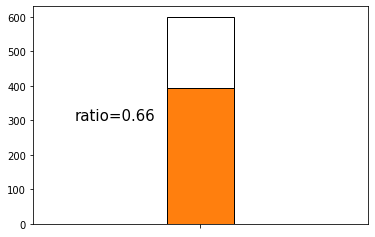

In [20]:
std = np.sqrt(2)
obserr_no0 = X_obserr[:,::obs_intv].ravel()
total_size = obserr_no0.size
within_size = np.sum((obserr_no0 >= -2*std) & (obserr_no0 <= 2*std))

plt.bar(0, total_size, facecolor='white', edgecolor='k')
plt.bar(0, within_size, edgecolor='k')
plt.xlim([-2, 2])
plt.xticks([0], [])
plt.text(-1.5, 300, f'ratio={within_size/total_size:.2f}', fontsize=15);

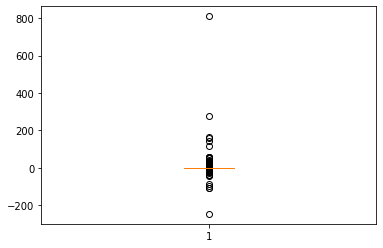

In [21]:
plt.boxplot(X_obserr.ravel());

(-100, 100)

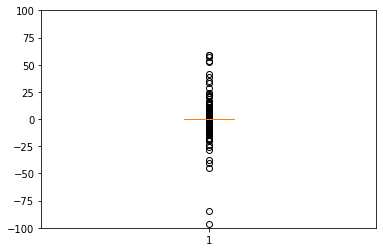

In [22]:
plt.boxplot(X_obserr.ravel())
plt.ylim([-100, 100])

### QC for cauchy

#### Just simply replace the original observation by truth value if the observation value is greater than |N$\sqrt{2}$|, N=2,3,4,5.

N=2, RMSE mean=0.8664, RMSE variance=0.3743
N=3, RMSE mean=1.0208, RMSE variance=0.5218
N=4, RMSE mean=1.1925, RMSE variance=0.5440
N=5, RMSE mean=1.2825, RMSE variance=0.7525


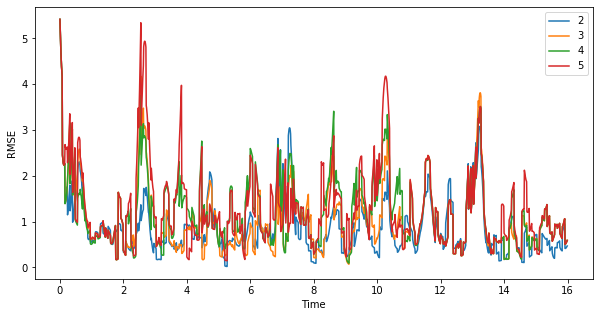

In [23]:
plt.figure(figsize=(10, 5))

obsqc = {}
for N in range(2, 6):
    std = np.sqrt(2)
    X_obserr_qc = X_obserr.copy()
    X_obserr_qc[np.abs(X_obserr) >= N*std] = 0

    X_obs_qc = X_nature + X_obserr_qc
    X_obs_qc = X_obs_qc[:,::obs_intv]
    obsqc[N] = X_obs_qc

    ekf = ExtendedKF(lorenz63_fdm, dt)
    ekf.list_params()
    params = {
        'X_ini': X_ini,
        'obs': X_obs_qc,
        'obs_interv': 8,
        'Pb': Pb,
        'R': R,
        'H_func': lambda arr: arr,
        'H': np.eye(3),
        'M': lambda X: M(X.ravel(), dt),
        'alpha': 0.3,
        'inflat': 1.4
    }
    ekf.set_params(**params)
    ekf.cycle()

    rmse_ekf = RMSE(ekf.analysis, X_nature)
    plt.plot(ts, rmse_ekf, label=str(N))
    print(f'N={N}, RMSE mean={rmse_ekf.mean():.4f}, RMSE variance={rmse_ekf.var():.4f}')
    
plt.legend()
plt.xlabel('Time')
plt.ylabel('RMSE');

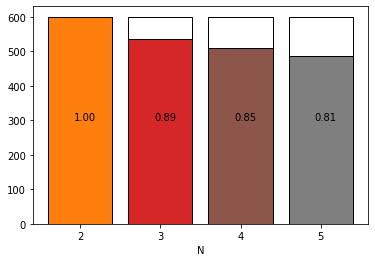

In [24]:
std = np.sqrt(2)
for N, obsq in obsqc.items():
    obsq_err = obsq - X_nature[:,::obs_intv]
    
    total_size = obsq_err.size
    within_size = np.sum((obsq_err >= -2*std) & (obsq_err <= 2*std))
    
    plt.bar(N, total_size, facecolor='white', edgecolor='k')
    plt.bar(N, within_size, edgecolor='k')
    plt.text(N-0.08, 300, f'{within_size/total_size:.2f}')

plt.xticks([i for i in range(2, 6)])
plt.xlabel('N');